# Predicting Household Income

The target of this machine learning project is to predict household income, specifically household income classified as at least or below $70,000 dollars a year.

## Ingestion and Wrangling of CE Data

The target and features will come from the [Consumer Expenditure (CE) Interview survey](https://www.bls.gov/cex/pumd_data.htm). The files contain data about the household for each survey quarter and another file contains information about each member of the household. Descriptions of all the variables provided in the data can be found on the [CE data dictionary](https://www.bls.gov/cex/pumd/ce_pumd_interview_diary_dictionary.xlsx).

#### Libraries

In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import sqlite3
import zipfile

#Feature Importance, Selection, Preprocessing
from yellowbrick.features import Rank2D, RadViz
from yellowbrick.model_selection import FeatureImportances
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Classification Models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#Metrics
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

#Export Fits
import joblib

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Ingestion

Download CE data, extract files, output.

### Download CE Data

The CE program provides the data as a ZIP file.

In [2]:
response = requests.get("https://www.bls.gov/cex/pumd/data/comma/intrvw18.zip")

In [3]:
z = zipfile.ZipFile(io.BytesIO(response.content))

### Extraction and Output

Print table names for the file naming conventions.

In [4]:
z.namelist()[:5]

['intrvw18/expn18/',
 'intrvw18/expn18/apa18.csv',
 'intrvw18/expn18/apb18.csv',
 'intrvw18/expn18/cla18.csv',
 'intrvw18/expn18/cld18.csv']

Analysis is limited to one quarter of households from the CE Interview, needing only two tables **fmli182.csv, memi182.csv**.

In [5]:
tables = ['intrvw18/fmli182.csv', 'intrvw18/memi182.csv']

for table in tables:
    table_name = table.split('/')[1].split('.')[0]
    print(table_name)

fmli182
memi182


To keep with Write One Read Many (WORM) methodology consider a secure storage process.

In [6]:
conn = sqlite3.connect('../data/ce_intrvw_data.db')
c = conn.cursor()

for table in tables:
    table_name = table.split('/')[1].split('.')[0]
    
    intrvw = pd.read_csv(z.open(table))

    c.execute("drop table if exists {}".format(table_name))

    intrvw.to_sql(table_name, conn)

conn.commit()
conn.close()

## Wrangling

Categorizing CE income levels for classification models, feature generation by aggregating hours worked by all members, output after wrangling process.

### Describe, Classify, Encode Income

*Describe*

The income variable is an integer that represents the "total amount of family income before taxes, after imputation". Missing values from data collection have already been imputed where appropriate.

In [7]:
conn = sqlite3.connect('../data/ce_intrvw_data.db')

fmli_df = pd.read_sql('''select * from fmli182''', conn)
memi_df = pd.read_sql('''select * from memi182''', conn)

conn.close()

Describe the income variable with a boxplot. From the boxplot there are income values that are below zero. Investigation shows negative incomes (losses) from rental income or self-proprietorship.

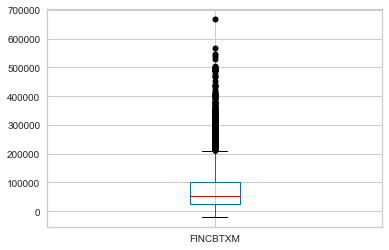

In [8]:
fmli_df.boxplot(column='FINCBTXM', flierprops=dict(markerfacecolor='black'))

*Classify*

The goals of the project require households are classified at least or below 70k.

In [9]:
lim = 70000

fmli_df.loc[fmli_df['FINCBTXM'] >= lim, 'income_class'] = ">=70k"
fmli_df.loc[fmli_df['FINCBTXM'] < lim, 'income_class'] = "<70k"

A bar chart shows a slight imbalance of our target. Any imbalance in this case would make it harder for our model to accurately learn and identify households with greater than 70k.

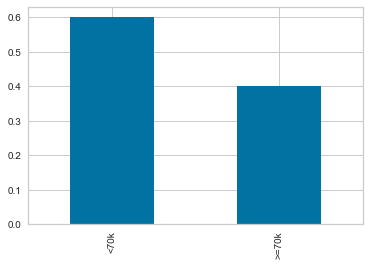

In [10]:
fmli_df['income_class'].value_counts(normalize=True).plot(kind='bar')

*Label Encoding*

In [11]:
le = LabelEncoder()

ic_fit = le.fit(fmli_df['income_class'])

print(ic_fit.classes_)

['<70k' '>=70k']


In [12]:
fmli_df['inc_class_encode'] = ic_fit.transform(fmli_df['income_class'])

As part the pipeline process output any label encoding parameters.

In [13]:
joblib.dump(ic_fit, '../model/income-encoding-fit.sav')

['../model/income-encoding-fit.sav']

### Aggregate Hours Worked

Aggregate the number of hours worked by members of the household and merge the results.

In [14]:
hh_hrs_wrkd = memi_df.groupby(by='NEWID', as_index=False)['INC_HRSQ'].sum()

In [15]:
wng_df = fmli_df.merge(hh_hrs_wrkd, how='left', on='NEWID')

### Output

While all in one notebook, it is good practice to output after the wrangling process.

In [16]:
table_name = 'final_family_data'

conn = sqlite3.connect('../data/ce_intrvw_data.db')
c = conn.cursor()

c.execute("drop table if exists {}".format(table_name))

wng_df.to_sql(table_name, conn)

conn.commit()
conn.close()

# Data Exploration & Feature Selection

Utilizing the Yellowbrick library to assess the relationship between features, scale (standardize) features, and perform feature selection using feature elimination techniques.

## Feature Relationships

There are over 800 variables on the dataset, including indicators and data surely not helpful in predicting the target. For the sake of this exercise, I will apply some subject matter expertise to reduce the number of variables.

In [17]:
conn = sqlite3.connect('../data/ce_intrvw_data.db')

wng_fmly_df = pd.read_sql('''select * from final_family_data''', conn)

conn.close()

In [18]:
columns = ['income_class','inc_class_encode','FINCBTXM','NO_EARNR','AGE_REF','MARITAL1','AS_COMP1','AS_COMP2',
           'AS_COMP3','AS_COMP4','AS_COMP5','PERSOT64','BLS_URBN','CUTENURE',
           'FAM_SIZE','FAM_TYPE','HIGH_EDU','VEHQ','VEHQL','INC_HRSQ']

wng_fmly_df = wng_fmly_df[columns]

In [19]:
wng_fmly_df.describe()

,inc_class_encode,FINCBTXM,NO_EARNR,AGE_REF,MARITAL1,AS_COMP1,AS_COMP2,AS_COMP3,AS_COMP4,AS_COMP5,PERSOT64,BLS_URBN,CUTENURE,FAM_SIZE,FAM_TYPE,HIGH_EDU,VEHQ,VEHQL,INC_HRSQ
count,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000
mean,0.400068,76524.821224,1.254111,52.312765,2.299203,0.904052,1.016443,0.222750,0.210375,0.051026,0.420241,1.067469,2.370571,2.404645,5.253094,13.813697,1.829293,0.079166,49.678929
std,0.489953,74865.766394,0.967608,17.677242,1.587341,0.648928,0.636225,0.549254,0.544389,0.232798,0.686944,0.250854,1.333626,1.414880,3.138196,1.691453,1.450500,0.315215,39.894660
min,0.000000,-19708.600000,0.000000,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,26358.000000,1.000000,37.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,12.000000,1.000000,0.000000,10.000000
50%,0.000000,53728.400000,1.000000,53.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,6.000000,14.000000,2.000000,0.000000,40.000000
75%,1.000000,100205.900000,2.000000,66.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000,3.000000,8.000000,15.000000,2.000000,0.000000,80.000000
max,1.000000,667400.300000,6.000000,88.000000,5.000000,5.000000,5.000000,4.000000,5.000000,2.000000,4.000000,2.000000,6.000000,9.000000,9.000000,16.000000,13.000000,4.000000,265.000000


#### 2DRank

2DRank will use a inform me as to the colinearity between our features. Expected results arise: positive relationship between family size and and the number of household members, the position relationship between the age of the reference person and number of household members over the age of 64, the number of income earners and the total number of working hours by income earners in the household.

In [20]:
feature_list = columns[3:]
target_list = columns[1]

features = wng_fmly_df[feature_list]
target = wng_fmly_df[target_list]

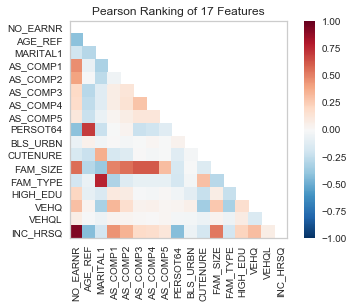

In [21]:
viz = Rank2D(features=feature_list, algorithm='pearson')

viz.fit(features, target)
viz.transform(features)
viz.poof()

#### RadViz

Using the RadViz visualizer to assess separability of the two classes, at least or below 70k income. Classes do not seem demonstrably separated on this chart and both are pulled towards the number of earners in the household, and the number of hours worked by the household.

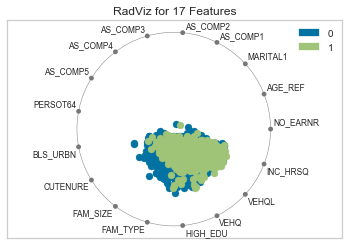

In [22]:
viz = RadViz()

viz.fit(features, target)
viz.transform(features)
viz.show()

## Feature Scaling (Standardization)

Assess the need for preprocessing and re-scaling of our features before feature selection. Standardizations will need to be performed on the features, not the target since the target is binary (categorical). [StandardScalar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) is an intuitive choice for those with a basic background in statistics.

*Before Standardization*

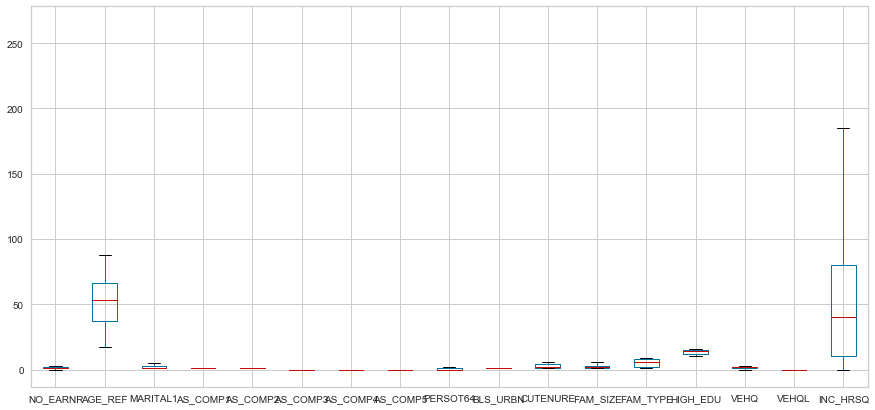

In [23]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)

features.boxplot(ax=ax)

*After Standardization*

In [24]:
stnd_scaler = StandardScaler()
stnd_scaler_df= pd.DataFrame(stnd_scaler.fit_transform(features), columns=feature_list)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


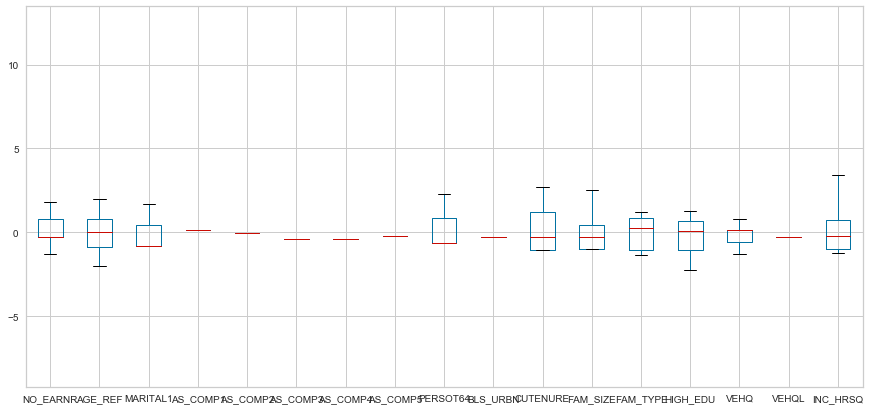

In [25]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)

stnd_scaler_df.boxplot(ax=ax)

## Feature Importance and Selection

Feature importances with the goal of selection using [recursive feature elimination and cross-validated (rfecv)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html). The feature importance and recursive feature elimination charts for both the Random Forest Classifier (RFC) and the Gradient Boosting Classifier (GBC) are below. The RFC and GBC models suggests about 10 and 6 features, respectively, depending on the run, suggesting feature elimination is optimal.

Overlap between the models is an indicator of features to include. I suspect that the GBC model noticed the correlation between the features the GBC model included and the features excluded by the GBC model but included in the RFC model. I got the impression that the RFC model is over-fitting by including them. Since GBC suggestions are a subset of those suggested by RFC, I will continue with those suggested by th latter to begin modeling.

*Feature Selection with Random Forest Classifier*

In [26]:
rfecv = RFECV(estimator=RandomForestClassifier(n_estimators=10),
              step=1,
              cv=StratifiedKFold(12),
              scoring='accuracy',
              verbose=10,
              n_jobs=-1)

In [27]:
rfecv.fit(stnd_scaler_df, target)
print(rfecv.n_features_)

Fitting estimator with 17 features.
16


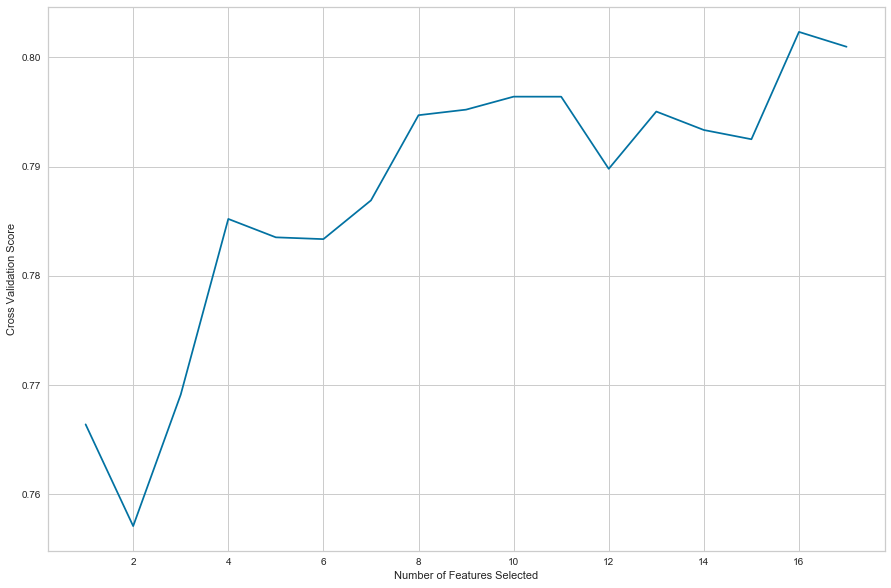

In [28]:
plt.figure(figsize=(15, 10))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross Validation Score")

plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plt.show()

In [29]:
for index in np.where(rfecv.support_)[0]:
    print(stnd_scaler_df.columns[index])

NO_EARNR
AGE_REF
MARITAL1
AS_COMP1
AS_COMP2
AS_COMP3
AS_COMP4
PERSOT64
BLS_URBN
CUTENURE
FAM_SIZE
FAM_TYPE
HIGH_EDU
VEHQ
VEHQL
INC_HRSQ


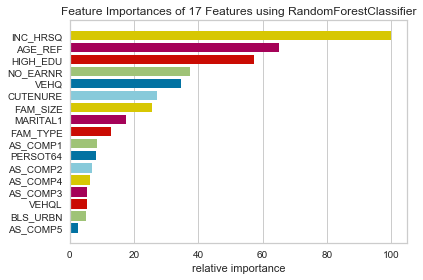

In [30]:
viz = FeatureImportances(RandomForestClassifier(n_estimators=10))
viz.fit(stnd_scaler_df, target)
viz.poof()

*Feature Selection with Gradient Boosting Classifier*

In [31]:
rfecv = RFECV(estimator=GradientBoostingClassifier(),
              step=1,
              cv=StratifiedKFold(12),
              scoring='accuracy',
              verbose=10,
              n_jobs=-1)

In [32]:
rfecv.fit(stnd_scaler_df, target)
print(rfecv.n_features_)

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
6


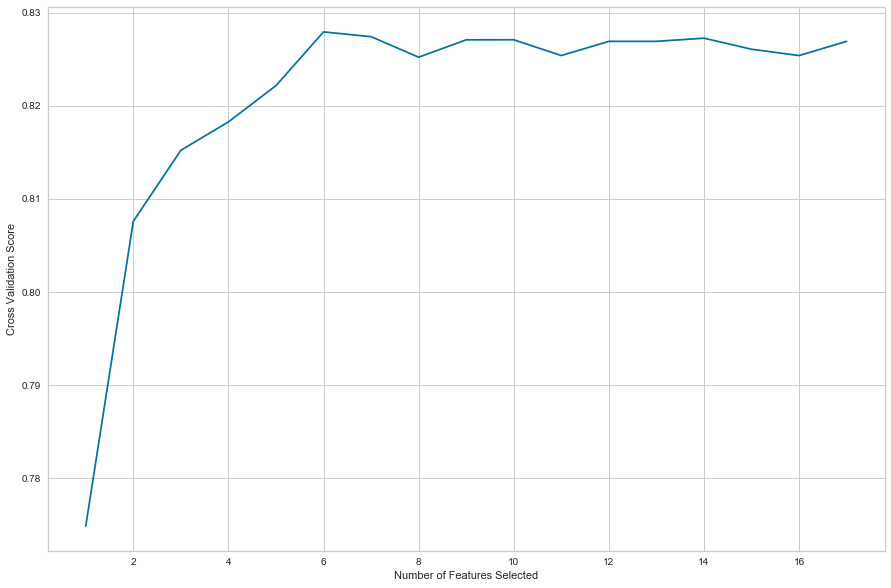

In [33]:
plt.figure(figsize=(15, 10))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross Validation Score")

plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plt.show()

In [34]:
for index in np.where(rfecv.support_)[0]:
    print(stnd_scaler_df.columns[index])

AGE_REF
CUTENURE
FAM_TYPE
HIGH_EDU
VEHQ
INC_HRSQ


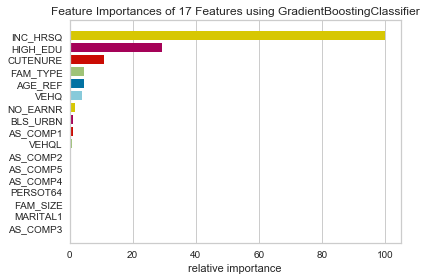

In [35]:
viz = FeatureImportances(GradientBoostingClassifier())
viz.fit(stnd_scaler_df, target)
viz.poof()

# Model Selection and Evaluation

To continue along the pipeline, the next part covers data preprocessing, modeling using multiple classifiers, modeling evaluation using Yellowbrick's classification reports and analysis, hyper-parameter tuning, and model output.

## Preprocesisng

*Import*

In [36]:
conn = sqlite3.connect('../data/ce_intrvw_data.db')

wng_fmly_df = pd.read_sql('''select * from final_family_data''', conn)

conn.close()

*Subset*

In [37]:
columns = ['income_class','inc_class_encode','NO_EARNR','AGE_REF','MARITAL1','AS_COMP1','CUTENURE',
           'FAM_SIZE','FAM_TYPE','HIGH_EDU','VEHQ','INC_HRSQ']

wng_fmly_df = wng_fmly_df[columns]

In [38]:
feature_list = columns[2:]
target_list = columns[1]

X = wng_fmly_df[feature_list]
y = wng_fmly_df[target_list]

*Train-Test-Split and Scale*

Standardize data *after* splitting into test and training data. Otherwise, you run the risk of leaking information since technically data your model should not be aware of was used in the scaling of your training dataset.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
scaler = StandardScaler()

X_train_fit = scaler.fit(X_train)
X_test_fit = scaler.fit(X_test)

X_train_scale = X_train_fit.transform(X_train)
X_test_scale = X_test_fit.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


Output fit for training model.

In [41]:
joblib.dump(X_train_fit, '../model/feature-scaling-fit.sav')

['../model/feature-scaling-fit.sav']

## Modeling, Evaluation, Tuning

### Modeling
- Random Forest Classifier
- Gradient Boosting Classifier
- K-Nearest Neighbors Classifier

In [42]:
models_list = [
    ['GradientBoosting',GradientBoostingClassifier()],
    ['RandomForestClassifier',RandomForestClassifier()],
    ['KNN',KNeighborsClassifier()],
]

In [43]:
models_dict = {}

for name, model in models_list:
    fit = model.fit(X_train_scale, y_train)

    models_dict[name] = fit

    print("{} fitted".format(name))

GradientBoosting fitted
RandomForestClassifier fitted
KNN fitted


### Evaluation

#### Overall Accuracy

Overall accuracy suggests Gradient Boosting model is optimal, closely followed up KNN and Random Forest.

In [44]:
for name, model in models_dict.items():
    print(name, ":", accuracy_score(y_test, model.predict(X_test_scale)))

GradientBoosting : 0.8220338983050848
RandomForestClassifier : 0.7974576271186441
KNN : 0.7906779661016949


#### Classification Reports

The classification reports are confirm what the RadViz chart earlier: All models have a hard time distinguishing between the classes. The classification reports also suggest that models performed similarly, having a harder time classifying those households with at least 70k accurately than households with less than.

In [45]:
# 1: >=70k, 0: <70k
classes = ["<70k", ">=70k"]

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


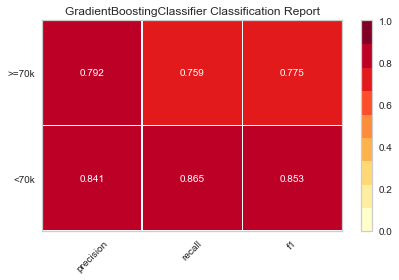

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


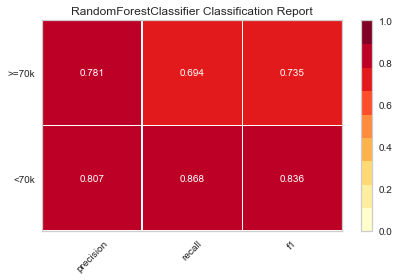

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


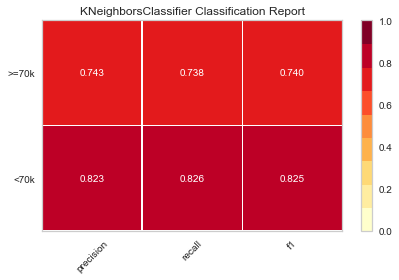

In [46]:
for name, model in models_dict.items():
    cr = ClassificationReport(model, classes=classes)
    cr.score(X_test_scale, y_test)
    cr.poof()

#### Confusion Matrix

The confusion matrices reiterate the difficulty with differentiating the classes, particularly those truly at least 70k. That is, the model misclassified a greater percentage of households actually at least 70k as less than 70k than the converse.

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


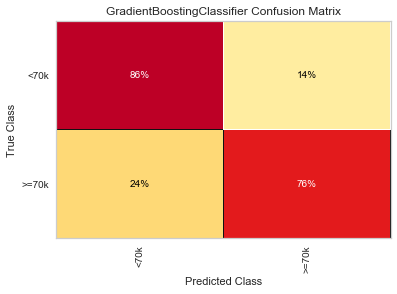

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


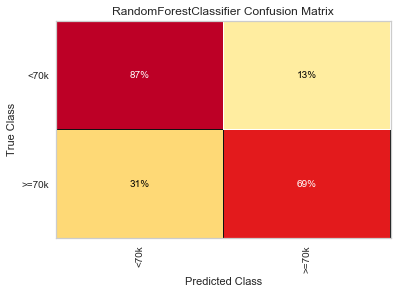

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


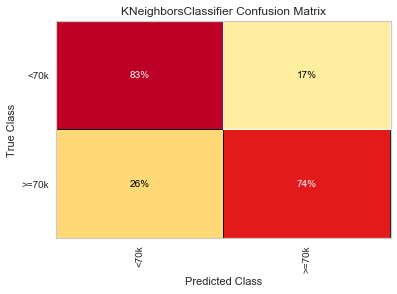

In [47]:
for name, model in models_dict.items():
    cm = ConfusionMatrix(model, percent=True, classes=classes)
    cm.score(X_test_scale, y_test)
    cm.poof()

#### Binary class ROC/AUC

The ROC/AUC provides more evidence that the Gradient Boosting Classifier is out performing the other models with a steeper ROC curve and highest AUC of 0.91.

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


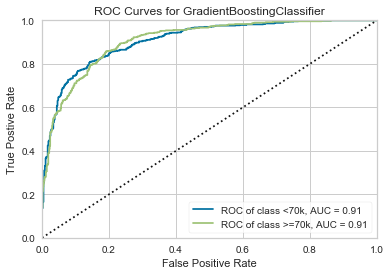

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


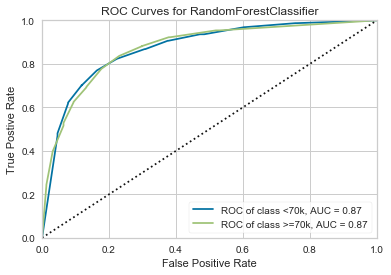

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


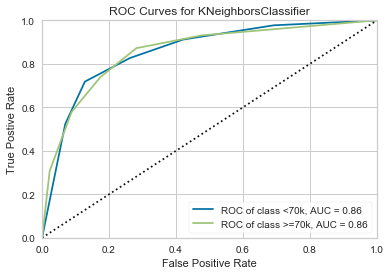

In [48]:
for name, model in models_dict.items():
    prc = ROCAUC(model, classes=classes, micro=False, macro=False)
    prc.score(X_test_scale, y_test)
    prc.poof()

### Hyper-parameter Tuning

Let's perform a simplistic hyper-parameter tuning exercise.

In [49]:
model_params = [{'name':'GBC',
                 'model':GradientBoostingClassifier(),
                 'parameters':{'learning_rate':[0.1, 0.2, 0.3, 0.01],
                               'n_estimators':[1, 10, 50, 100, 300, 500]}},
                {'name':'RFC',
                 'model':RandomForestClassifier(),
                 'parameters':{'max_depth':[1, 10, 50],
                               'n_estimators':[1, 10, 50, 100, 300, 500]}},
                {'name':'KNN',
                 'model':KNeighborsClassifier(),
                 'parameters':{'n_neighbors':[1, 3, 5, 7, 10, 50]}}]

In [50]:
for model in model_params:
    #Set
    grid_search = GridSearchCV(estimator=model['model'],
                           param_grid=model['parameters'],
                           scoring='accuracy',
                           cv=4,
                           n_jobs=-1,
                           verbose=10)
    
    #Train
    grid_search = grid_search.fit(X_train_scale, y_train)
    
    #Score
    score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    #Print
    print(model['name'], score, best_params)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   13.9s finished


GBC 0.8260224623860988 {'learning_rate': 0.01, 'n_estimators': 500}
Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0156s.) Setting batch_size=24.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   16.8s finished


RFC 0.8205128205128205 {'max_depth': 10, 'n_estimators': 300}
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    1.9s remaining:    0.3s


KNN 0.8103411739775376 {'n_neighbors': 50}


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.6s finished


### Model Output

Apply the suggested hyper-parameters and save the Gradient Boosting Classifier model.

In [51]:
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500)

In [52]:
gbc_fit = model.fit(X_train_scale, y_train)

In [53]:
print(accuracy_score(y_test, model.predict(X_test_scale)))

0.8271186440677966


In [54]:
joblib.dump(gbc_fit, '../model/gradient-classifier-fit.sav')

['../model/gradient-classifier-fit.sav']